# 信息抽取
https://python.langchain.com/docs/use_cases/extraction/

In [5]:
#导入语言模型
import os
from langchain_community.llms import Tongyi
from langchain_community.llms import SparkLLM
from langchain_community.llms import QianfanLLMEndpoint

import pandas as pd
#导入模版
from langchain.prompts import PromptTemplate

#导入聊天模型
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from langchain_community.chat_models import ChatSparkLLM
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_community.chat_models import QianfanChatEndpoint

#输入三个模型各自的key

os.environ["DASHSCOPE_API_KEY"] = ""

os.environ["IFLYTEK_SPARK_APP_ID"] = ""
os.environ["IFLYTEK_SPARK_API_KEY"] = ""
os.environ["IFLYTEK_SPARK_API_SECRET"] = ""

os.environ["QIANFAN_AK"] = ""
os.environ["QIANFAN_SK"] = ""

from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [6]:
model_ty = Tongyi(temperature=0)
model_qf = QianfanLLMEndpoint(temperature=0)
model_sp = ChatSparkLLM()

In [7]:
from dashscope import Generation
import dashscope
from langchain.tools.render import render_text_description
 
dashscope.api_key = ""

In [4]:
import langchain
langchain.__version__

'0.1.9'

In [35]:
import networkx

In [1]:
#! pip install openpyxl -i https://mirrors.aliyun.com/pypi/simple

In [58]:
#! pip install matplotlib -i https://mirrors.aliyun.com/pypi/simple

## langchain的信息抽取

https://python.langchain.com/docs/use_cases/extraction/

* 大模型信息抽取的三种方式

1. 工具/函数调用模式：一些LLM支持工具或函数调用模式，可以根据给定的模式构建输出。一般来说，这种方法最容易使用，并且有望产生良好的结果。

2. JSON 模式：一些 LLM 可以强制输出有效的 JSON。这与工具/函数调用方法类似，只不过输出模式是作为提示的一部分提供的。一般来说，我们的直觉是，这比工具/函数调用方法的性能更差，但不要相信我们并针对您自己的用例进行验证！

https://blog.csdn.net/wshzd/article/details/135834436

3. 基于提示：可以很好地遵循说明的LLM可以被指示生成所需格式的文本。可以使用现有的输出解析器或使用自定义解析器将生成的文本解析为结构化格式（例如 JSON）。此方法可用于不支持 JSON 模式或工具/函数调用模式的 LLM。这种方法具有更广泛的适用性，但可能会比针对提取或函数调用进行微调的模型产生更差的结果。

* llm.with_structured_output(schema=Person)  方法的作用

https://github.com/langchain-ai/langchain/blob/a4896da2a0264c3405b5a97d03fff673ddee8402/libs/partners/openai/langchain_openai/chat_models/base.py#L765

### 单个对象的抽取

In [11]:
from typing import Optional

from langchain_core.pydantic_v1 import BaseModel, Field


class Person(BaseModel):
    """Information about a person."""
    name: Optional[str] = Field(default=None, description="The name of the person")
    hair_color: Optional[str] = Field(default=None, description="The color of the peron's hair if known")
    height_in_meters: Optional[str] = Field(default=None, description="Height measured in meters")

In [12]:
from typing import Optional

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from the text. "
            "If you do not know the value of an attribute asked to extract, "
            "return null for the attribute's value.",
        ),
        ("human", "{text}"),
    ]
)

In [13]:
from langchain_core.utils.function_calling import convert_to_openai_tool

In [14]:
convert_to_openai_tool(Person)

{'type': 'function',
 'function': {'name': 'Person',
  'description': 'Information about a person.',
  'parameters': {'type': 'object',
   'properties': {'name': {'description': 'The name of the person',
     'type': 'string'},
    'hair_color': {'description': "The color of the peron's hair if known",
     'type': 'string'},
    'height_in_meters': {'description': 'Height measured in meters',
     'type': 'string'}}}}}

In [22]:
class Person(BaseModel):
    """Information about a person."""
    name: Optional[str] = Field(default=None, description="The name of the person")
    hair_color: Optional[str] = Field(default=None, description="The color of the peron's hair if known")
    height_in_meters: Optional[str] = Field(default=None, description="Height measured in meters")
    
def get_response_1t(mess):
    response = Generation.call(
        model='qwen-plus',
        messages=mess,
        tools=[convert_to_openai_tool(Person)],
        result_format='message', # 将输出设置为message形式
    )
    return response

def prompt_ty(input):
    pro_sys="You are an expert extraction algorithm.Only extract relevant information from the text.If you do not know the value of an attribute asked to extract,return null for the attribute's value."
    return [{"role":"system","content":pro_sys},{"role":"user","content":input}]

In [30]:
p_y

[{'role': 'system',
  'content': "You are an expert extraction algorithm.Only extract relevant information from the text.If you do not know the value of an attribute asked to extract,return null for the attribute's value."},
 {'role': 'user', 'content': 'Alan Smith is 6 feet tall and has blond hair.'}]

In [26]:
p_y=prompt_ty("Alan Smith is 6 feet tall and has blond hair.")
res=get_response_1t(p_y)

In [29]:
print(res.output.choices[0].message["tool_calls"][0])

{'function': {'name': 'Person', 'arguments': '{"properties": {"hair_color": "blond", "height_in_meters": "1.83", "name": "Alan Smith"}}'}, 'id': '', 'type': 'function'}


### 多个对象的抽取和样本的使用

In [62]:
from typing import List, Optional

class Person(BaseModel):
    """Information about a person."""
    name: Optional[str] = Field(default=None, description="The name of the person")
    hair_color: Optional[str] = Field(default=None, description="The color of the peron's hair if known")
    height_in_meters: Optional[str] = Field(default=None, description="Height measured in meters")

class Data(BaseModel):
    """Extracted data about people."""
    people: List[Person]

def get_response_1t(mess):
    response = Generation.call(
        model='qwen-plus',
        messages=mess,
        tools=[convert_to_openai_tool(Data)],
        result_format='message', # 将输出设置为message形式
    )
    return response

def prompt_ty(input):
    pro_sys="You are an expert extraction algorithm.Only extract relevant information from the text.If you do not know the value of an attribute asked to extract,return null for the attribute's value."
    return [{"role":"system","content":pro_sys},{"role":"user","content":"Alan Smith is 6 feet tall and has blond hair."},\
            {'role': 'assistant', 'content':"",'tool_calls': [{'function': {'name': 'Data', 'arguments': '{"people": [{"name": "Alan Smith", "hair_color": "Blond", "height_in_meters": "1.83"}]}'}, 'id': '', 'type': 'function'}]},{"role":"user","content":input}]

In [45]:
p_y=prompt_ty("Alan Smith is 6 feet tall and has blond hair.")
res=get_response_1t(p_y)

In [53]:
res_ex

GenerationResponse(status_code=<HTTPStatus.OK: 200>, request_id='c1ca95cd-d417-9906-8dae-7bbc858bf2d9', code='', message='', output=GenerationOutput(text=None, choices=[Choice(finish_reason='tool_calls', message=Message({'role': 'assistant', 'content': "Based on the information provided:\n\n- Name: Alan Smith\n- Hair Color: Blond\n- Height in Meters: To convert feet to meters, we can use the conversion factor of 1 foot = 0.3048 meters. Let's calculate Alan's height.", 'tool_calls': [{'function': {'name': 'Data', 'arguments': '{"people": [{"name": "Alan Smith", "hair_color": "Blond", "height_in_meters": "6 feet"}]}'}, 'id': '', 'type': 'function'}]}))], finish_reason=None), usage=GenerationUsage(input_tokens=300, output_tokens=96))

In [47]:
res_ex=res

In [52]:
res_ex.output.choices[0].message["tool_calls"]

[{'function': {'name': 'Data',
   'arguments': '{"people": [{"name": "Alan Smith", "hair_color": "Blond", "height_in_meters": "6 feet"}]}'},
  'id': '',
  'type': 'function'}]

In [63]:
text = "My name is Jeff, my hair is black and i am 6 feet tall. Anna has the same color hair as me."
p_y=prompt_ty(text)
res=get_response_1t(p_y)

In [64]:
res

GenerationResponse(status_code=<HTTPStatus.OK: 200>, request_id='1424993c-9270-9021-934f-fe6a2cda5736', code='', message='', output=GenerationOutput(text=None, choices=[Choice(finish_reason='tool_calls', message=Message({'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'Data', 'arguments': '{"people": [{"name": "Jeff", "hair_color": "Black", "height_in_meters": "1.83"}, {"name": "Anna", "hair_color": "Black", "height_in_meters": null}]}'}, 'id': '', 'type': 'function'}]}))], finish_reason=None), usage=GenerationUsage(input_tokens=377, output_tokens=60))

In [65]:
print(res.output.choices[0].message["tool_calls"][0])

{'function': {'name': 'Data', 'arguments': '{"people": [{"name": "Jeff", "hair_color": "Black", "height_in_meters": "1.83"}, {"name": "Anna", "hair_color": "Black", "height_in_meters": null}]}'}, 'id': '', 'type': 'function'}


In [32]:
convert_to_openai_tool(Data)

{'type': 'function',
 'function': {'name': 'Data',
  'description': 'Extracted data about people.',
  'parameters': {'type': 'object',
   'properties': {'people': {'type': 'array',
     'items': {'description': 'Information about a person.',
      'type': 'object',
      'properties': {'name': {'description': 'The name of the person',
        'type': 'string'},
       'hair_color': {'description': "The color of the peron's hair if known",
        'type': 'string'},
       'height_in_meters': {'description': 'Height measured in meters',
        'type': 'string'}}}}},
   'required': ['people']}}}

In [21]:
text = "My name is Jeff, my hair is black and i am 6 feet tall. Anna has the same color hair as me."

In [47]:
text = "The solar system is large, but earth has only 1 moon."

In [49]:
res.output.choices[0].message

Message({'role': 'assistant', 'content': "The text you provided does not contain information about the number of people or their specific details. It discusses the size of the solar system and the fact that Earth has only one moon. Here's the relevant information:\n\n- Solar System Size: Large (not quantified)\n- Earth's Moons: 1 (specifically, the Moon)\n\nIf you need a count of people or details about individuals, please provide another text."})

## 基于大模型抽取人物关系图谱

* 文档的分割
* 案例的重要性

In [68]:
from langchain.document_loaders import TextLoader
loader_txt = TextLoader(r'F:\langchain\云岚宗.txt', encoding='utf8')
docs_txt = loader_txt.load()

In [69]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# 导入递归字符文本分割器
text_splitter_txt = RecursiveCharacterTextSplitter(chunk_size = 300, chunk_overlap = 0, separators=["\n\n", "\n", " ", "", "。", "，"])
# 导入文本
documents_txt = text_splitter_txt.split_documents(docs_txt)

In [71]:
len(documents_txt)

9

In [72]:
documents_txt[0].page_content

'第四章 云岚宗\n\n大厅中,萧战以及三位长老,正在颇为热切的与那位陌生老者交谈着,不过这位老者似乎有什么难以启齿的事情一般,每每到口的话语,都将会有些无奈的咽了回去,而每当这个时候,一旁的娇贵少女,都是忍不住的横了老者一眼…\n\n    倾耳听了一会，萧炎便是有些无聊的摇了摇头…\n\n    “萧炎哥哥，你知道他们的身份吗？”就在萧炎无聊得想要打瞌睡之时，身旁的熏儿，纤指再次翻开古朴的书页，目不斜视的微笑道。\n\n    “你知道？”好奇的转过头来，萧炎惊诧的问道。\n\n    “看见他们袍服袖口处的云彩银剑了么？”微微一笑，熏儿道。'

In [74]:
class Relation(BaseModel):
    """两个人物之间的关系"""
    name0: Optional[str] = Field(default=None, description="一个人物的名称")
    name1: Optional[str] = Field(default=None, description="另一个人物的名称")
    guanxi: Optional[str] = Field(default=None, description="两个人物间的关系")

class Data_guanxi(BaseModel):
    """抽取人物间关系数据"""
    relation: List[Relation]

def prompt_yun(ct):
    system_prompt="您是提取算法专家。仅从文本中提取相关信息。如果您不知道要求提取的属性值，则为属性值返回 null。首先确定文本中包含哪些人物角色，给出这些人物角色间的关系"
    prompt=[{"content":system_prompt,"role":"system"},\
            {"role":"user","content":"小明上学路上看手机，被小强的足球踢脸上了，小红看见了哈哈大笑"},\
            {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'Data_yun', 'arguments': '{"relation": [{"name0": "小明","name1": "小强","guanxi": "小明被小强把球踢脸上了"},{"name0": "小红","name1": "小明","guanxi": "小明被小红嘲笑了"}]}'}}]}]
    prompt.append({"role":"user","content":ct})
    return prompt

def get_response_1t(mess):
    response = Generation.call(
        model='qwen-plus',
        messages=mess,
        tools=[convert_to_openai_tool(Data_guanxi)],
        result_format='message', # 将输出设置为message形式
    )
    return response

In [79]:
documents_txt[0].page_content

'第四章 云岚宗\n\n大厅中,萧战以及三位长老,正在颇为热切的与那位陌生老者交谈着,不过这位老者似乎有什么难以启齿的事情一般,每每到口的话语,都将会有些无奈的咽了回去,而每当这个时候,一旁的娇贵少女,都是忍不住的横了老者一眼…\n\n    倾耳听了一会，萧炎便是有些无聊的摇了摇头…\n\n    “萧炎哥哥，你知道他们的身份吗？”就在萧炎无聊得想要打瞌睡之时，身旁的熏儿，纤指再次翻开古朴的书页，目不斜视的微笑道。\n\n    “你知道？”好奇的转过头来，萧炎惊诧的问道。\n\n    “看见他们袍服袖口处的云彩银剑了么？”微微一笑，熏儿道。'

In [80]:
text = documents_txt[0].page_content
p_y=prompt_yun(text)
res=get_response_1t(p_y)

In [91]:
res_relation=parser.parse(res.output.choices[0].message['tool_calls'][0]['function']['arguments'])['relation']
res_relation

[{'name0': '萧战', 'name1': '三位长老', 'guanxi': '与...交谈'},
 {'name0': '陌生老者', 'name1': '萧战', 'guanxi': '与...交谈'},
 {'name0': '娇贵少女', 'name1': '老者', 'guanxi': '横了...一眼'},
 {'name0': '萧炎', 'name1': '熏儿', 'guanxi': '对话'}]

In [88]:
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser()
output_dict = parser.parse('{"result": "2 + 2 = 4", "mode": "math_operation"}')
output_dict

{'result': '2 + 2 = 4', 'mode': 'math_operation'}

In [46]:
text = documents_txt[0].page_content

In [47]:
res.output.choices[0].message

Message({'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'Data_yun', 'arguments': '{"relation": [{"name0": "萧炎", "name1": "萧战", "guanxi": "正在交谈"}, {"name0": "萧炎", "name1": "三位长老", "guanxi": "正在交谈"}, {"name0": "一位陌生老者", "name1": "萧炎", "guanxi": "交谈时老者有难言之隐"}, {"name0": "娇贵少女", "name1": "老者", "guanxi": "少女对老者不满（可能是因为老者的犹豫）"}, {"name0": "熏儿", "name1": "萧炎", "guanxi": "向萧炎询问身份"}]}'}, 'id': '', 'type': 'function'}]})

In [48]:
print(res.output.choices[0].message["tool_calls"][0]['function']['arguments'])

{"relation": [{"name0": "萧炎", "name1": "萧战", "guanxi": "正在交谈"}, {"name0": "萧炎", "name1": "三位长老", "guanxi": "正在交谈"}, {"name0": "一位陌生老者", "name1": "萧炎", "guanxi": "交谈时老者有难言之隐"}, {"name0": "娇贵少女", "name1": "老者", "guanxi": "少女对老者不满（可能是因为老者的犹豫）"}, {"name0": "熏儿", "name1": "萧炎", "guanxi": "向萧炎询问身份"}]}


In [93]:
#正常显示画图时出现的中文和负号
from pylab import mpl
import networkx as nx
import matplotlib.pyplot as plt
import random

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [52]:
res_relation

[{'name0': '萧炎', 'name1': '萧战', 'guanxi': '正在交谈'},
 {'name0': '萧炎', 'name1': '三位长老', 'guanxi': '正在交谈'},
 {'name0': '一位陌生老者', 'name1': '萧炎', 'guanxi': '交谈时老者有难言之隐'},
 {'name0': '娇贵少女', 'name1': '老者', 'guanxi': '少女对老者不满（可能是因为老者的犹豫）'},
 {'name0': '熏儿', 'name1': '萧炎', 'guanxi': '向萧炎询问身份'}]

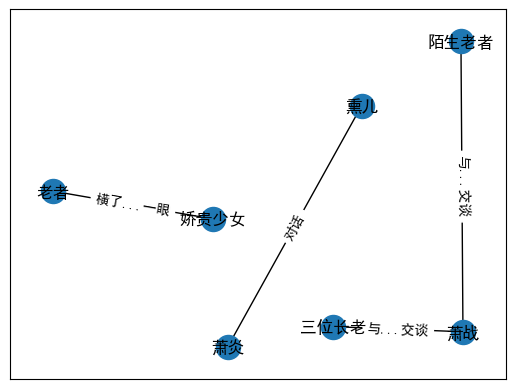

In [94]:
G = nx.Graph()
for i in res_relation:
    G.add_edge(i["name0"], i['name1'], name=i['guanxi'])
pos = nx.spring_layout(G) 

for i in pos.keys():
    pos[i][0]=pos[i][0]+random.randint(0, 20)
    pos[i][1]=pos[i][1]+random.randint(0, 20)
    
nx.draw_networkx(G, pos=pos)
edge_labels = nx.get_edge_attributes(G, 'name')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

## 基于大模型的商品评论分析

In [56]:
import pandas as pd

In [60]:
df=pd.read_excel(r"F:\langchain\原始数据.xlsx")

In [61]:
df.columns

Index(['Class_Name', 'Clothing_ID', 'Department_Name', 'Division_Name',
       'Review_Text', 'Title', 'Age', 'F0', 'Positive_Feedback_Count',
       'Rating', 'Recommended_IND'],
      dtype='object')

In [135]:
df.head(2)

,Class_Name,Clothing_ID,Department_Name,Division_Name,Review_Text,Title,Age,F0,Positive_Feedback_Count,Rating,Recommended_IND
0,Intimates,767,Intimate,Initmates,Absolutely wonderful - silky and sexy and comf...,NaN,33,0,0,4,1
1,Dresses,1080,Dresses,General,Love this dress! it's sooo pretty. i happene...,NaN,34,1,4,5,1


In [144]:
df[df["Rating"]<2].groupby("Clothing_ID").size().sort_values().tail(10)

Clothing_ID
1056    11
1072    13
820     13
829     14
867     16
1081    16
868     19
1094    24
1078    29
862     34
dtype: int64

In [65]:
re_862=df[(df["Rating"]<2)&(df["Clothing_ID"]==862)].Review_Text.tolist()

In [154]:
re_862[1]

'The material is cheap and looks torn. not as nice as the picture.'

In [62]:
class clothing(BaseModel):
    """Reasons for negative user reviews"""
    Fabric_problems: Optional[str] = Field(default=None, description="Fabric problems: noticeable holes, loose threads, pilling, or abnormal color fading and shrinkage")
    Workmanship_defects: Optional[str] = Field(default=None, description="Workmanship defects: poor stitching, excessive loose threads, easily detachable buttons, etc")
    Size_discrepancies : Optional[str] = Field(default=None, description="Size discrepancies: the actual product size differs from the described dimensions, leading to ill-fitting garments.")
    Uncomfortable_wear : Optional[str] = Field(default=None, description="non-breathable fabrics, irritation against the skin, or discomfort during wear.")
    Fit_design: Optional[str] = Field(default=None, description="Fit and design: unsuitable cut, not conforming to ergonomics, or unflattering when worn")
    Appearance_Discrepancies: Optional[str] = Field(default=None, description="Mismatch between the product received and online images in terms of style or color.")
    After_Sales: Optional[str] = Field(default=None, description="Unsatisfactory customer service attitude or response efficiency.")
    Value_Money: Optional[str] = Field(default=None, description="Consumers feel that the price does not align with the actual quality or value of the product, perceiving it as overpriced.")

class Data_yun(BaseModel):
    """Extraction of user negative review information"""
    comment: List[clothing]

In [2]:
#convert_to_openai_tool(Data_yun)

In [66]:
text = re_862[4]
p_y=prompt_yun(text)
res=get_response_yun(p_y)

In [188]:
print(res.output.choices[0].message["tool_calls"][0]['function']['arguments'])

{"comment": [{"Size_discrepancies": "shrank significantly after washing, became unwearable", "Workmanship_defects": "poor shrink resistance"}]}


In [180]:
re_862[4]

'I loved this shirt until the first time i washed it. it shrunk so much it became unwearable. when i returned it the salesperson said she had also bought this shirt and the same thing happened.'

In [189]:
res.output.choices[0].message["tool_calls"][0]['function']['arguments']

'{"comment": [{"Size_discrepancies": "shrank significantly after washing, became unwearable", "Workmanship_defects": "poor shrink resistance"}]}'

In [211]:
dict0

{'Fit_design': 25,
 'Fabric_problems': 5,
 'Appearance_Discrepancies': 6,
 'Size_discrepancies': 12,
 'Return_policy': 1,
 'Value_Money': 9,
 'Uncomfortable_wear': 4,
 'Workmanship_defects': 9,
 'Unsuitable_product': 1,
 'Quality': 1}

https://api.python.langchain.com/en/latest/_modules/langchain_anthropic/chat_models.html#ChatAnthropic.bind_tools

https://zhuanlan.zhihu.com/p/685741041

https://github.com/langchain-ai/langchain/blob/a4896da2a0264c3405b5a97d03fff673ddee8402/libs/partners/openai/langchain_openai/chat_models/base.py#L765

## 